In [12]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
from datetime import datetime, timedelta
from dateutil.parser import parse
import json

In [15]:
def plot_client_perspective(client_data, xticks:list[datetime]) -> tuple[datetime, datetime]:
    # Plots the line showing interruption from the client's perspective
    client_times: list[datetime] = []
    for entry in client_data:
        as_dt = parse(entry['time']) + timedelta(hours=-4)
        if as_dt < xticks[0] or as_dt > xticks[-1]:
            continue
        client_times.append(as_dt)

    biggest_gap = -1
    gap_ix = -1
    for ix in range(len(client_times) - 1):
        this_time = client_times[ix]
        next_time = client_times[ix + 1]
        this_gap = (next_time - this_time).seconds
        if this_gap > biggest_gap:
            biggest_gap = this_gap
            gap_ix = ix 
    
    result = (client_times[gap_ix], client_times[gap_ix + 1])

    fig, ax = plt.subplots(figsize=(8.8, 4), layout="constrained")
    # ax.set(title="Events observered during failover")

    ax.vlines(client_times, 0, [0 for thing in client_times], color="tab:red")  # The vertical stems.
    ax.plot(client_times, np.zeros_like(client_times), "-o",
            color="k", markerfacecolor="w", label="Writes that made it to the Database")

    # Hand draw label for client gap
    ax.annotate(f"Downtime observed by client\n{biggest_gap} seconds", xy=(client_times[gap_ix] + timedelta(seconds=biggest_gap / 2), 0),
                    xytext=(0,50), textcoords="offset points",
                    weight="bold",
                    fontsize=10,
                    horizontalalignment="center",
                    verticalalignment="top")

    ax.legend()

    # remove y-axis and spines
    ax.yaxis.set_visible(False)
    ax.spines[["left", "top", "right"]].set_visible(False)

    # Shade in the region with client downtime
    ax.axvspan(result[0], result[1], alpha=0.12, facecolor="r")

    ax.margins(y=0.1)

    plt.xlim(xticks[0], xticks[-1])
    ax.set_xticks(xticks)
    plt.setp(ax.get_xticklabels(), rotation=30, ha="right")
    ax.xaxis.set_major_locator(mdates.SecondLocator(interval=1))
    
    plt.show()

    return result

In [16]:
def to_datetime_comma(stamp: str):
    # Get a datetime from a string in our logs
    return datetime.strptime(stamp, '%Y-%m-%d %H:%M:%S,%f')

def to_datetime_period(stamp: str):
    # Get a datetime from a string in our logs
    return datetime.strptime(stamp, '%Y-%m-%d %H:%M:%S.%f')

def load_events(file: str):
    with open(file) as json_file:
        return json.load(json_file)["data"]

def plot_events(
        old_events, 
        new_events, 
        xticks:list[datetime], 
        title: str, 
        outage: tuple[datetime, datetime], 
        new_loc: tuple[datetime, float],
        old_loc: tuple[datetime, float],
        convert_func):
    # Plot an event (presumably from a source)
    old_staggers = [-x for x in range(1,8)]
    old_labels = [event["readable"] for event in old_events]
    old_levels = [old_staggers[ix % len(old_staggers)] for ix in range(len(old_labels))]
    old_times = [convert_func(event["timestamp"]) for event in old_events]

    new_staggers = [x for x in range(1,8)]
    new_labels = [event["readable"] for event in new_events]
    new_levels = [new_staggers[ix % len(new_staggers)] for ix in range(len(new_labels))]
    new_times = [convert_func(event["timestamp"]) for event in new_events]

    fig, ax = plt.subplots(figsize=(8.8, 4), layout="constrained")
    ax.set(title=title)

    labels = old_labels + new_labels
    levels = old_levels + new_levels
    times = old_times + new_times

    chunks = sorted(zip(labels, levels, times), key=lambda i: i[2])

    ax.vlines(old_times, 0, old_levels, color="tab:blue")
    ax.vlines(new_times, 0, new_levels, color="tab:green")
    ax.hlines([0], [xticks[0]], [xticks[-1]], linestyles=["dashed"])
    ax.plot(times, np.zeros_like(times), "-o",
            color="k", markerfacecolor="w")
    
    for ix, (r, l, d) in enumerate(chunks):
        ax.annotate(f"{ix}. {r}", xy=(d,l), xytext=(-3, np.sign(l)*3), textcoords="offset points",
                    horizontalalignment="right",
                    verticalalignment="bottom" if l > 0 else "top")
    
    # Shade in the region with client downtime
    ax.axvspan(outage[0], outage[1], alpha=0.12, facecolor="r", label="Outage from Client's Perspective")
    ax.legend()

    # Hand draw above/below labels for clarity
    ax.annotate("New Primary Events", xy=new_loc,
                    xytext=(-3,4), textcoords="offset points",
                    weight="bold",
                    fontsize=16,
                    color="green",
                    horizontalalignment="center",
                    verticalalignment="top")

    ax.annotate("Old Primary Events", xy=old_loc,
                    xytext=(-3,4), textcoords="offset points",
                    weight="bold",
                    fontsize=16,
                    color="blue",
                    horizontalalignment="center",
                    verticalalignment="top")

    plt.xlim(xticks[0], xticks[-1])
    ax.set_xticks(xticks)
    ax.xaxis.set_major_locator(mdates.SecondLocator(interval=1))
    plt.setp(ax.get_xticklabels(), rotation=30, ha="right")

    # remove y-axis and spines
    ax.yaxis.set_visible(False)
    ax.spines[["left", "top", "right"]].set_visible(False)

    ax.margins(y=0.1)
    plt.show()

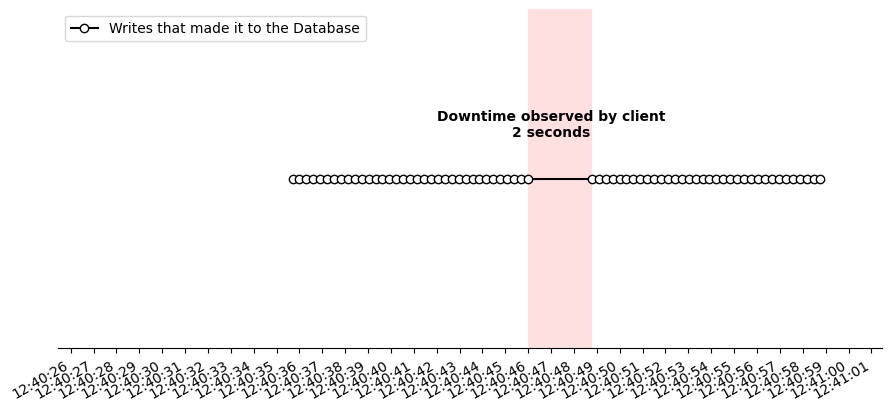

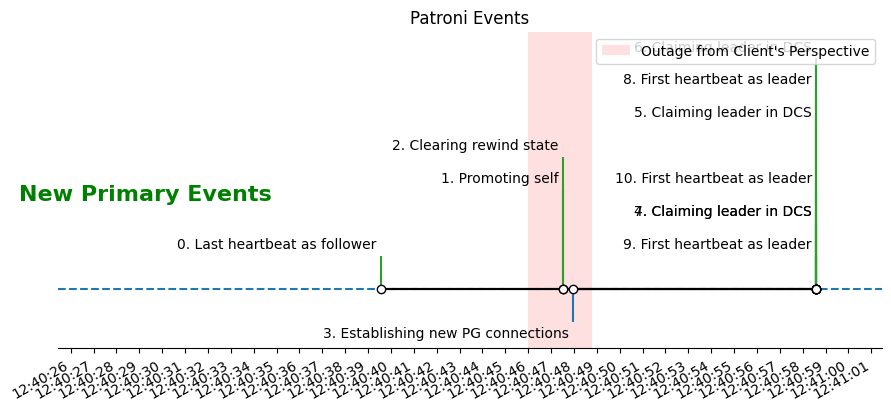

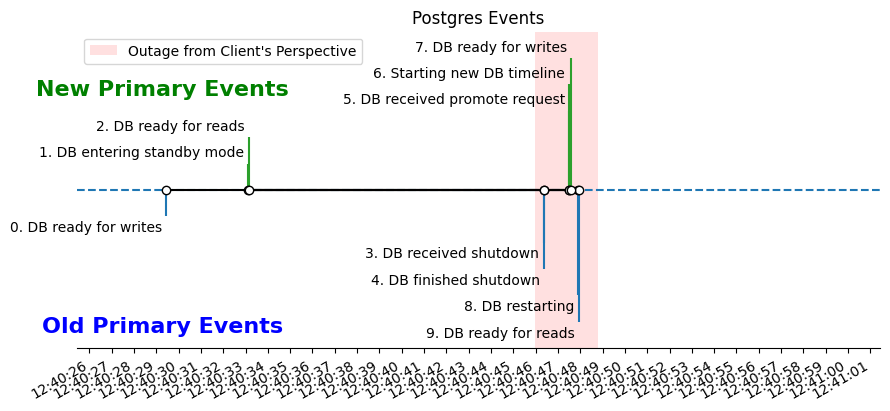

In [20]:
run = "test"

# First get the events and figure out the window of time to plot
POL_events = load_events(f"runs/{run}/POL_data.json")
PNL_events = load_events(f"runs/{run}/PNL_data.json")
GOL_events = load_events(f"runs/{run}/GOL_data.json")
GNL_events = load_events(f"runs/{run}/GNL_data.json")

min_time = min(
    to_datetime_comma(POL_events[0]["timestamp"]),
    to_datetime_comma(PNL_events[0]["timestamp"]),
    to_datetime_period(GOL_events[0]["timestamp"]),
    to_datetime_period(GNL_events[0]["timestamp"])
)
max_time = max(
    to_datetime_comma(POL_events[-1]["timestamp"]),
    to_datetime_comma(PNL_events[-1]["timestamp"]),
    to_datetime_period(GOL_events[-1]["timestamp"]),
    to_datetime_period(GNL_events[-1]["timestamp"])
)
xticks = [
    min_time + timedelta(seconds=-4),
    min_time + timedelta(seconds=-3),
    min_time + timedelta(seconds=-2),
    min_time + timedelta(seconds=-1),
    min_time,
]
while min_time <= max_time + timedelta(seconds=2):
    min_time += timedelta(seconds=1)
    xticks.append(min_time)

with open(f"runs/{run}/ClientPerspective.json") as json_file:
        client_data = json.load(json_file)

outage = plot_client_perspective(client_data = client_data, xticks=xticks)
plot_events(
    POL_events, 
    PNL_events, 
    xticks=xticks, 
    title="Patroni Events", 
    outage=outage,
    new_loc=(xticks[4],3),
    old_loc=(xticks[4],-5),
    convert_func=to_datetime_comma
)
plot_events(
    GOL_events, 
    GNL_events, 
    xticks=xticks, 
    title="Postgres Events", 
    outage=outage,
    new_loc=(xticks[4],4),
    old_loc=(xticks[4],-5), 
    convert_func=to_datetime_period
)

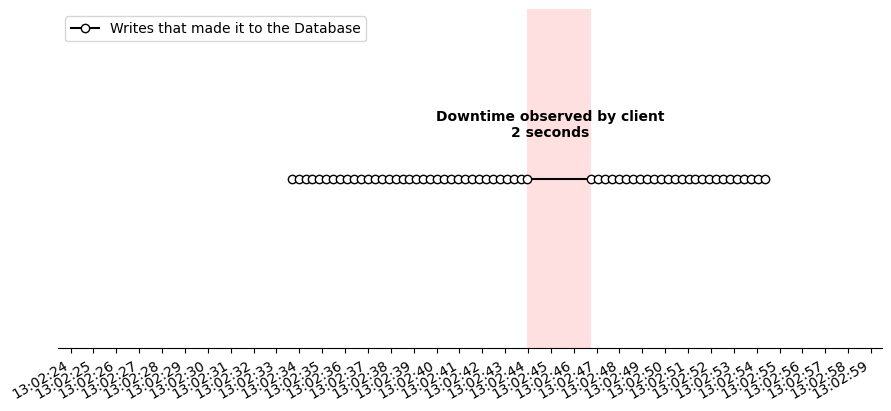

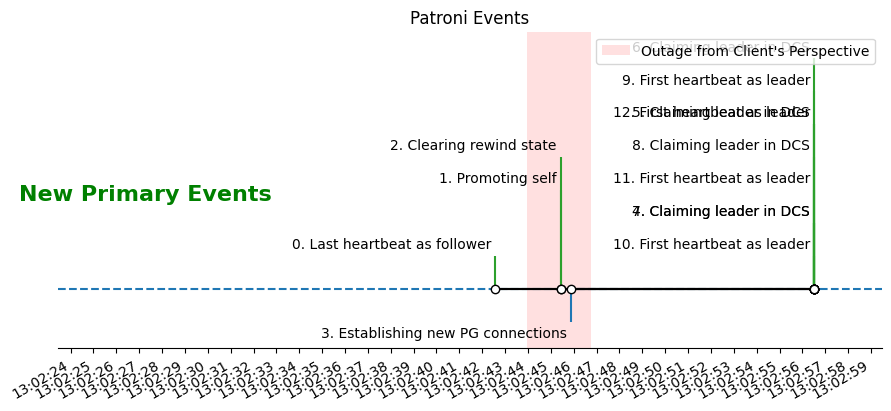

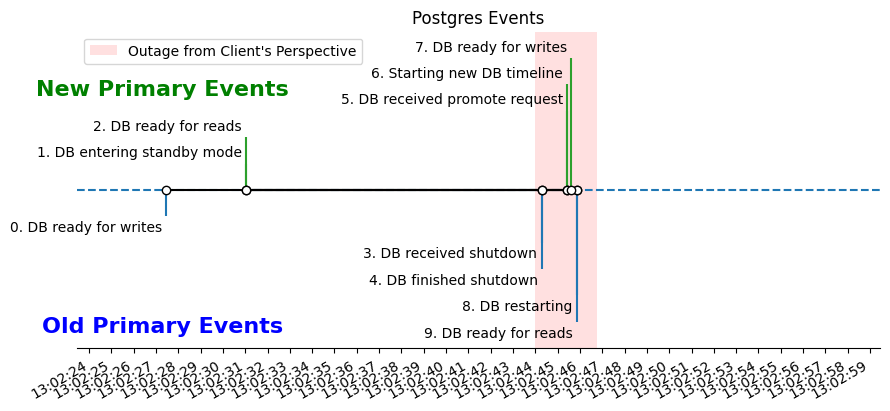

In [21]:
run = "long_sudden"

# First get the events and figure out the window of time to plot
POL_events = load_events(f"runs/{run}/POL_data.json")
PNL_events = load_events(f"runs/{run}/PNL_data.json")
GOL_events = load_events(f"runs/{run}/GOL_data.json")
GNL_events = load_events(f"runs/{run}/GNL_data.json")

min_time = min(
    to_datetime_comma(POL_events[0]["timestamp"]),
    to_datetime_comma(PNL_events[0]["timestamp"]),
    to_datetime_period(GOL_events[0]["timestamp"]),
    to_datetime_period(GNL_events[0]["timestamp"])
)
max_time = max(
    to_datetime_comma(POL_events[-1]["timestamp"]),
    to_datetime_comma(PNL_events[-1]["timestamp"]),
    to_datetime_period(GOL_events[-1]["timestamp"]),
    to_datetime_period(GNL_events[-1]["timestamp"])
)
xticks = [
    min_time + timedelta(seconds=-4),
    min_time + timedelta(seconds=-3),
    min_time + timedelta(seconds=-2),
    min_time + timedelta(seconds=-1),
    min_time,
]
while min_time <= max_time + timedelta(seconds=2):
    min_time += timedelta(seconds=1)
    xticks.append(min_time)

with open(f"runs/{run}/ClientPerspective.json") as json_file:
        client_data = json.load(json_file)

outage = plot_client_perspective(client_data = client_data, xticks=xticks)
plot_events(
    POL_events, 
    PNL_events, 
    xticks=xticks, 
    title="Patroni Events", 
    outage=outage,
    new_loc=(xticks[4],3),
    old_loc=(xticks[4],-5),
    convert_func=to_datetime_comma
)
plot_events(
    GOL_events, 
    GNL_events, 
    xticks=xticks, 
    title="Postgres Events", 
    outage=outage,
    new_loc=(xticks[4],4),
    old_loc=(xticks[4],-5), 
    convert_func=to_datetime_period
)